## An example-based introduction to pymc3-kalman

In [11]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


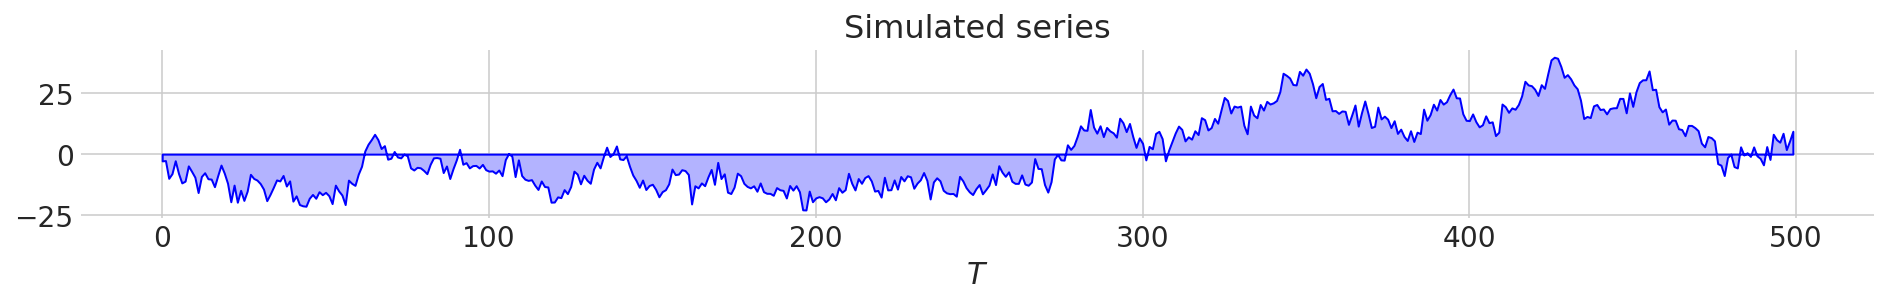

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

# True values
T = 500  # Time steps
sigma2_eps0 = 3  # Variance of the observation noise
sigma2_eta0 = 10  # Variance in the update of the mean

# Simulate data
np.random.seed(12345)
eps = np.random.normal(scale=sigma2_eps0 ** 0.5, size=T)
eta = np.random.normal(scale=sigma2_eta0 ** 0.5, size=T)
mu = np.cumsum(eta)
y = mu + eps

# Plot the time series
fig, ax = plt.subplots(figsize=(13, 2))
ax.fill_between(np.arange(T), 0, y, facecolor=(0.7, 0.7, 1), edgecolor=(0, 0, 1))
ax.set(xlabel="$T$", title="Simulated series")

In [8]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Consider the following AR(1) process, initialized in the infinite past:

𝑦𝑡=𝜃𝑦𝑡−1+𝜖𝑡,
where 𝜖𝑡∼𝑖𝑖𝑑(0,1). Suppose you’d like to learn about 𝜃 from a a sample of observations 𝑌𝑇={𝑦0,𝑦1,…,𝑦𝑇}.

First, let’s generate some synthetic sample data. We simulate the ‘infinite past’ by generating 10,000 samples from an AR(1) process and then discarding the first 5,000:

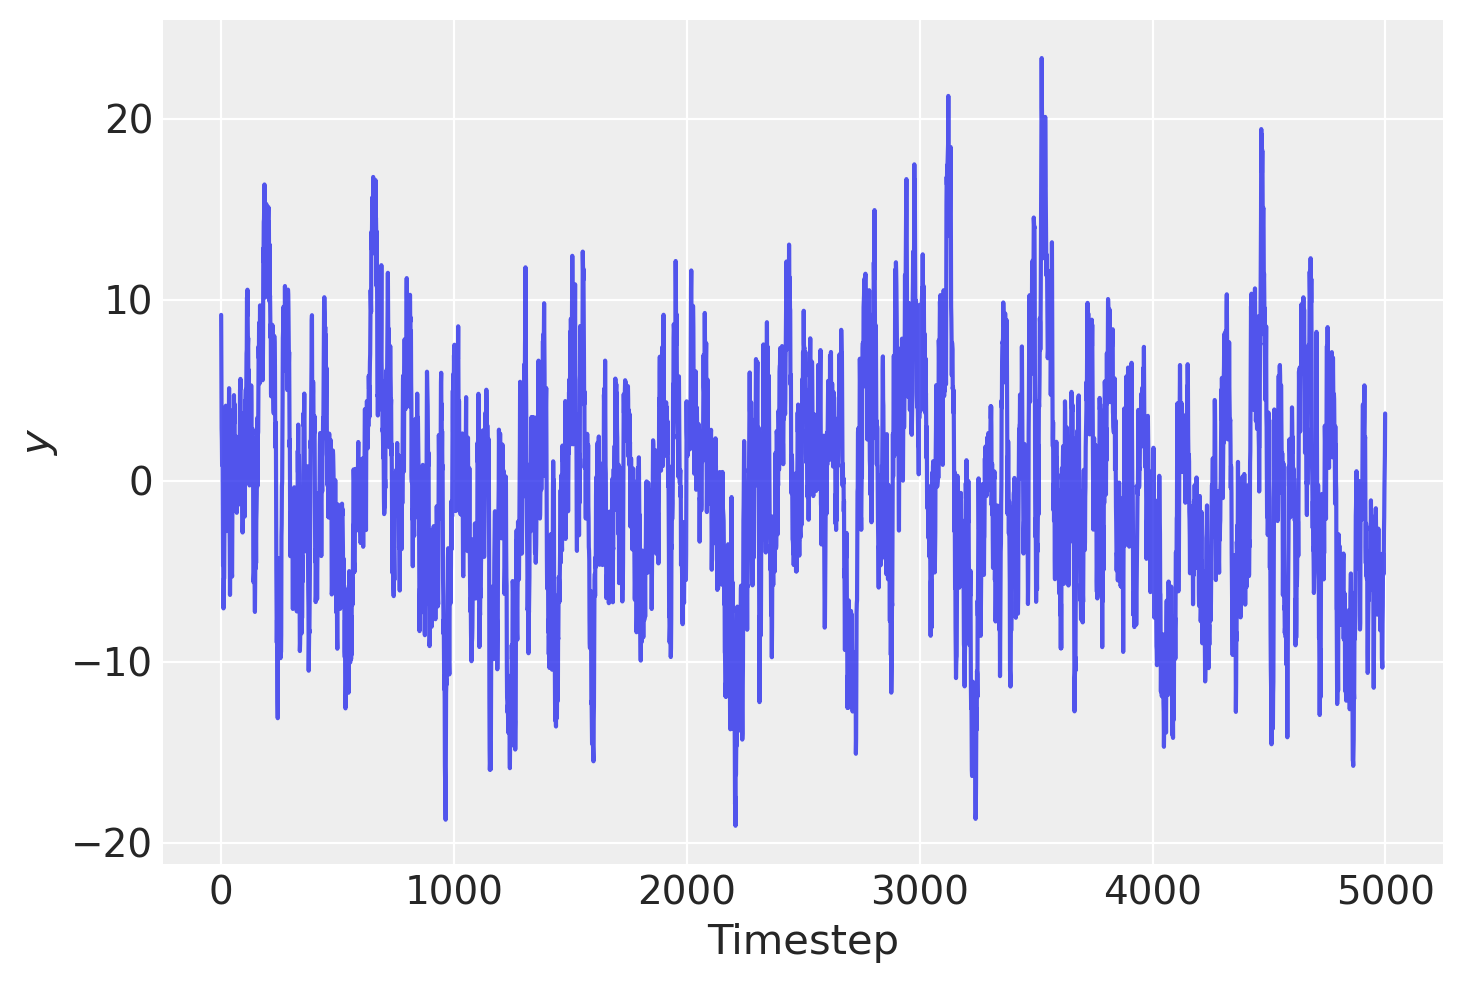

In [9]:
T = 10000
y = np.zeros((T,))

# true stationarity:
true_theta = 0.95
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = 0.0

for t in range(1, T):
    y[t] = true_theta * y[t - 1] + np.random.normal(loc=true_center, scale=true_sigma)

y = y[-5000:]
plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$")

In [10]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    theta = pm.Normal("theta", 0.0, 1.0)
    # precision of the innovation term
    tau = pm.Exponential("tau", 0.5)
    # process mean
    center = pm.Normal("center", mu=0.0, sigma=1.0)

    likelihood = pm.AR1("y", k=theta, tau_e=tau, observed=y - center)

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

<ipython-input-10-2e42c128ea15>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:3200: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: invalid value encountered in log
  return np.log(x)
Interrupted at 91 [0%]: Average Loss = 2.0183e+05
INFO:pymc3.variational.inference:Interrupted at 91 [0%]: Average Loss = 2.0183e+05
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'theta': 1.4419235957271428, 'tau_log__': 0.8362299476363515, 'center': 0.18421242047535438, 'tau': 2.30765059292103}

Initial evaluation results:
theta       -1.96
tau_log__   -1.01
center      -0.94
y            -inf
Name: Log-probability of test_point, dtype: float64

In [ ]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_sigma ** -2),
        ("center", {}, true_center),
    ],
);

In [ ]:
with pm.Model() as ar2:
    theta = pm.Normal("theta", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR("y", theta, sigma=sigma, observed=y)

    trace = pm.sample(
        1000,
        tune=2000,
        random_seed=RANDOM_SEED,
    )
    idata = az.from_pymc3(trace)

In [ ]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {"theta_dim_0": 0}, true_theta),
        ("theta", {"theta_dim_0": 1}, 0.0),
        ("sigma", {}, true_sigma),
    ],
);

In [ ]:
with pm.Model() as ar2_bis:
    beta0 = pm.Normal("theta0", mu=0.0, sigma=1.0)
    beta1 = pm.Uniform("theta1", -1, 1)
    sigma = pm.HalfNormal("sigma", 3)
    likelhood = pm.AR("y", [beta0, beta1], sigma=sigma, observed=y)

    trace = pm.sample(
        1000,
        tune=2000,
        random_seed=RANDOM_SEED,
    )
    idata = az.from_pymc3(trace)

In [ ]:
az.plot_trace(
    idata,
    lines=[("theta0", {}, true_theta), ("theta1", {}, 0.0), ("sigma", {}, true_sigma)],
);

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w